# KoLesky Test Suite

Testing the effect of different parameter (rho, neighbors, N) values on accuracy vs speed


### Imports and functions to interface with the KoLesky library

In [1]:
include("/home/pietaril/Documents/MI-AIM/julia/KoLesky.jl-master/src/KoLesky.jl")

using Random
using Plots
using StatsPlots
using Statistics
using StatsBase
using Distances


# ************************************** #
# Functions for example kernel modeling  #
# ************************************** #

# Square exponential kernel
function spherical_sqexp(d::T; logθ::AbstractVector{T}) where T <: Real
    exp(logθ[1]) * exp(-.5d^2 / (exp(logθ[2]) .^ 2))
end

# Matern 3/2 kernel
function Matern32(d::T; logθ::AbstractVector{T}) where T <: Real
    h = sqrt(3)*d / exp(logθ[2]) # d is Euclidean distance
    exp(logθ[1]) * (1. + h) * exp(-h)
end

# Function for computing kernel of new location vs training data
function kernel_matrix(X::Array{T}, l::Vector{T},  k::Function) where T
    d = pairwise(Euclidean(), X')
    k.(d; logθ = [0.0; l])
end

#*****************#
# Maija's helpers #
#*****************#

function compute_explicit_factor(x, K, rho, neighbors)
    #returns ExplicitKLFactorization explicit_factor 
    measurements = KoLesky.point_index_measurements(x)
    G = KoLesky.MatrixCovariance(K)
    implicit_factor = KoLesky.ImplicitKLFactorization(G, measurements, rho, neighbors)
    explicit_factor = KoLesky.ExplicitKLFactorization(implicit_factor)
    return explicit_factor
end    
    

function assemble_inv_covariance(factor::KoLesky.ExplicitKLFactorization)
    #returns approximation of the inverse of K
    U_matrix = Matrix(factor.U)
    inv_P = similar(factor.P)
    inv_P[factor.P] = 1 : length(inv_P)

    return (U_matrix * U_matrix')[inv_P, inv_P]
end 



assemble_inv_covariance (generic function with 1 method)

### Functions for testing

In [9]:
using DataFrames
import LinearAlgebra: norm, cholesky

function param_variation_test(Ns::AbstractVector{T}, rhos::AbstractVector{T}, neighborss::AbstractVector{T}) where T<:Real
    # Tests for timing Cholesky of Matern32 with l = [0.001]. Need to adjust this later to take also k and l as inputs so that they can also vary.
    # For some reason passing a funktion k didn't work
    results = DataFrame()
    l = [0.001]
    k = Matern32
    i = 0
    for N in Ns
        for rho in rhos
            for neighbors in neighborss
                    i += 1
                    x = rand(2, N);
                    K = kernel_matrix(x'[:,:],l,k);
                    t = @elapsed compute_explicit_factor(x, K, rho, neighbors)
                    push!(results, (id = i, N = N, rho = rho, n_neighbors = neighbors, time = t))
                
            end
        end
    end
    return results

end

param_variation_test (generic function with 3 methods)

In [ ]:
Ns = 1000:1000:10000
neighborss = 4:12
rhos = 2:8


df = param_variation_test(Ns, rhos, neighborss)

In [19]:
df

Row,id,N,rho,n_neighbors,time
,Int64,Int64,Int64,Int64,Float64
1,1,1000,2,4,0.0331697
2,2,1000,2,5,0.0540379
3,3,1000,2,6,0.0570487
4,4,1000,2,7,0.0458605
5,5,1000,2,8,0.0490999
6,6,1000,2,9,0.0554533
7,7,1000,2,10,0.0636479
8,8,1000,2,11,0.0918692
9,9,1000,2,12,0.0707889


Filter subsets where only one of the parameters N, rho, n_neighbors varies and other two are fixed

In [34]:
rho_N4_n10 = filter([:N, :n_neighbors] => (N, n) -> N == 10000 && n == 10, df)
rho_N4_n6 = filter([:N, :n_neighbors] => (N, n) -> N == 10000 && n == 6, df)
rho_N4_n8 = filter([:N, :n_neighbors] => (N, n) -> N == 10000 && n == 8, df)


Row,id,N,rho,n_neighbors,time
,Int64,Int64,Int64,Int64,Float64
1,572,10000,2,8,1.09551
2,581,10000,3,8,1.16098
3,590,10000,4,8,1.63543
4,599,10000,5,8,2.46273
5,608,10000,6,8,3.49779
6,617,10000,7,8,4.78481
7,626,10000,8,8,6.03474


┌ Warning: Skipped marker arg circle.
└ @ Plots /home/pietaril/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg circle.
└ @ Plots /home/pietaril/.julia/packages/Plots/rz1WP/src/args.jl:1148


┌ Warning: Skipped marker arg circle.
└ @ Plots /home/pietaril/.julia/packages/Plots/rz1WP/src/args.jl:1148


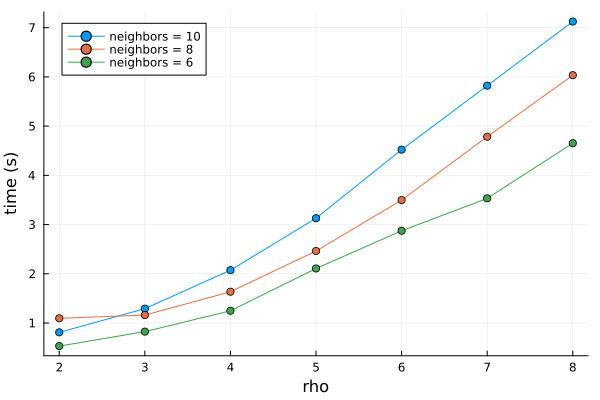

In [37]:
x = rho_N4_n10.rho
plot(x, rho_N4_n10.time, label="neighbors = 10", xlabel = "rho", ylabel = "time (s)", marker = "circle")
plot!(x, rho_N4_n8.time, label= "neighbors = 8", marker = "circle")
plot!(x, rho_N4_n6.time, label = "neighbors = 6", marker = "circle")



In [27]:
xys = []
for r_val in 2:2:8
    #extract subset of df corresponding to fixed rho and changing parameter value for r for plotting
    xy = filter([:rho, :n_neighbors] => (r, n) -> r == r_val && n == 8, df)
    push!(xys, ("r = $r_val", xy))
end




Row,id,N,rho,n_neighbors,time
,Int64,Int64,Int64,Int64,Float64
1,34,1000,5,10,0.136644
2,97,2000,5,10,0.373175
3,160,3000,5,10,0.728066
4,223,4000,5,10,1.26237
5,286,5000,5,10,1.46068
6,349,6000,5,10,1.71069
7,412,7000,5,10,2.11196
8,475,8000,5,10,2.42989
9,538,9000,5,10,2.63734


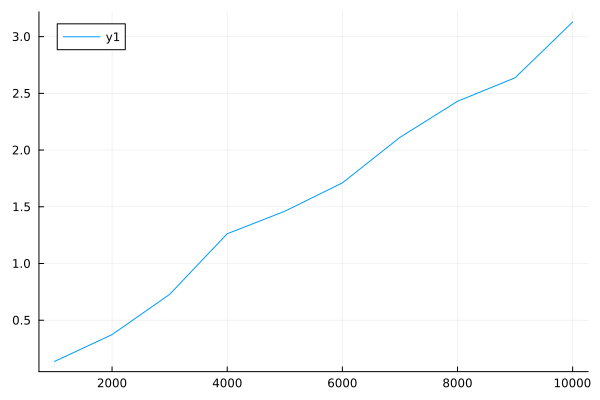

In [28]:
plot(N_times.N, N_times.time)

In [ ]:


# **********************#
# Compute factorization #
# **********************#

# Example random locations


N = 10000 # how many locations
x = rand(2,N) # random sampling


# Construct example spatial covariance matrix
# select kernel
#k = spherical_sqexp
k = Matern32
# length scale
l = [0.001]
# kernel matrix
K = kernel_matrix(x'[:,:],l,k)

# Control parameters for Florian's function
rho = 5 # accuracy of approximation. 2 = greedy, 8 = accurate but slow
neighbors = 5 # how many neighbors
n_samples = 100 # n samples from the spatial process


#************************************#
# Timing with different values for N #
#************************************#

import LinearAlgebra: norm, cholesky


times = []; #vector for timing results
times_ref = []; #reference times from LinearAlgebra.cholesky
rhos = 2:8
neighborss = 8:12



Ns = 1000:1000:10000 #start:step:stop makes a list 
using DataFrames


#the test function below needs to be corrected: since the input vectors
#are of different length, cannot just but forloops like that 
#and after the loops assemble the dataframe from input vectors and
#output vectors. Either different input & output vectors for Ns exact
#and assembling after loops, or assembling the dataframe on the go inside 
#the innermost loop so that separate vectors not needed for times 

#also: need to decide if I should compare to the time it takes to compute
#cholesky or permuted cholesky. 

# function param_variation_test(in_N, in_rho, in_neighbors)
#     for N in in_N
#         for rho in in_rho
#             for neighbors in in_neighborss
#                 x = rand(2, N)
#                 K = kernel_matrix(x'[:,:],l,k)
#                 push!(times) = @elapsed compute_explicit_factor(x, K, rho, neighbors);
#                 #how to get both the time and the output
#                 push!(times_ref) = @elapsed cholesky(K)
                
#             end
#         end
#     end

# end
using DataFrames




@time compute_explicit_factor(x, K, rho, neighbors);



 



# compute approximations of K and inv_K
#K_approx = KoLesky.assemble_covariance(factor)
#inv_K_approx = assemble_inv_covariance(factor)

#compare to exact

#inv_K = inv(K)



#relative error
#println(LinearAlgebra.norm(inv_K .- inv_K_approx)/LinearAlgebra.norm(inv_K))
#println(LinearAlgebra.norm(K .- K_approx)/LinearAlgebra.norm(K))

#check if inv_K_approx * K ≈ I
#inv_K_approx * K


# Largeish relative error between inv_K and inv_K_approx. 
# According to Otto this is probably due to U being a sparse approximation
# Compare instead U_approx to actual Cholesky U
U_approx = Matrix(factor.U)
C = cholesky(K[factor.P, factor.P])
U = inv(C.U)




#need to zoom in to see anything

U_slice = LinearAlgebra.UpperTriangular(U[1:20, 1:20])
U_approx_slice = LinearAlgebra.UpperTriangular(U_approx[1:20, 1:20])

println(U_slice)
println(U_approx_slice)